In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd "/content/drive/My Drive/Colab Notebooks/BERT-QEMP/"

/content/drive/My Drive/Colab Notebooks/BERT-QEMP


In [4]:
import os

In [5]:
root_dir = "/content/drive/My Drive/Colab Notebooks/BERT-QEMP/"

root_data_dir = os.path.join(root_dir, "datasets", "QEMP")

dataset = "train"
csv_file_path = "train.csv"

offline_model_file = os.path.join(root_dir, "BiLSTM-QEMP-model")
training_history_csv = "training_history.csv"

## Utils

In [6]:
def load_model():
    json_file = open(offline_model_file+".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    new_model = model_from_json(loaded_model_json)
    # load weights into new model
    new_model.load_weights(offline_model_file+".h5")
    print("Loaded model from disk")
    return new_model

In [7]:
def save_model(model):
    # serialize model to JSON
    model_json = model.to_json()
    
    with open(offline_model_file+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(offline_model_file+".h5")
    print("Saved model to disk")

In [8]:
def saveDataFrameToCSV(pd1, csv_path, append):  
  dataset_path = os.path.join(root_dir, csv_path)  
  
  if append:
    with open(dataset_path, 'a+') as f:    
      pd1.to_csv(dataset_path,  mode='a', index=False, header=False)    
  else:
    with open(dataset_path, 'a+') as f:    
      pd1.to_csv(dataset_path,  mode='a', index=False, header=True)

## Dataset Preprocessing


In [9]:
import os
import pandas as pd
import numpy as np

In [10]:
def loadData(csv_file_path):
  dataset_path = os.path.join(root_data_dir, csv_file_path)
  data = pd.read_csv(dataset_path, encoding="latin1")
  data = data.fillna(method="ffill")
  return data

In [11]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),                                                          
                                                        s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [12]:
data = loadData(csv_file_path)

In [13]:
data.head(10)

,Sentence #,Word,Tag
0,Sentence: 1,C,O
1,Sentence: 1,carbon,O
2,Sentence: 1,C/N,O
3,Sentence: 1,ratio,B-Quality
4,Sentence: 1,CSP,O
5,Sentence: 1,N,O
6,Sentence: 1,nitrogen,O
7,Sentence: 1,pH,B-Quality
8,Sentence: 1,S,B-Quality
9,Sentence: 1,SOC,O


In [14]:
test_data =  loadData("test.csv")

In [15]:
test_data.head(10)

,Sentence #,Word,Tag
0,Sentence: 1,The,O
1,Sentence: 1,commercial,O
2,Sentence: 1,use,O
3,Sentence: 1,of,O
4,Sentence: 1,any,O
5,Sentence: 1,data,O
6,Sentence: 1,is,O
7,Sentence: 1,prohibited,O
8,Sentence: 1,.,O
9,Sentence: 2,19-23,O


In [16]:
#if the data are in string style, we propably use tokenzer.fit_on_texts instead of list manipulation like here

VOCAB = list(set(list(data["Word"].values) + list(test_data["Word"].values)))
VOCAB.append("ENDPAD")

n_words = len(VOCAB) #n_words includes all vocab from train and validation test.
print(n_words)
print(VOCAB[n_words-1])

7520
ENDPAD


In [17]:
tags = list(set(data["Tag"].values))
n_tags = len(tags)
n_tags

9

In [18]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [19]:
getter_test = SentenceGetter(test_data)
sentences_test = getter_test.sentences

#### Exploration

In [20]:
sent = getter_test.get_next()
print(sent)

[('The', 'O'), ('commercial', 'O'), ('use', 'O'), ('of', 'O'), ('any', 'O'), ('data', 'O'), ('is', 'O'), ('prohibited', 'O'), ('.', 'O')]


In [21]:
sentences[1]

[('solution', 'O'),
 ('H2O', 'B-Material'),
 (':', 'O'),
 ('soil', 'B-Environment'),
 ('=', 'O'),
 ('2.5:1', 'O'),
 ('electrodes', 'O'),
 ('Sentix', 'O'),
 ('81', 'O'),
 ('and', 'O'),
 ('WTW', 'O'),
 ('pH-meter', 'O'),
 ('pH', 'B-Quality'),
 ('value', 'O'),
 ('(', 'O'),
 ('pH_KCl', 'O'),
 (')', 'O'),
 (',', 'O'),
 ('pH', 'B-Quality'),
 ('pH_KCl', 'O'),
 ('In', 'O'),
 ('case', 'O'),
 ('of', 'O'),
 ('H2O', 'B-Material'),
 (':', 'O'),
 ('samples', 'O'),
 ('were', 'O'),
 ('air-dried', 'O'),
 (',', 'O'),
 ('sieved', 'O'),
 ('<', 'O'),
 ('2mm', 'O'),
 (',', 'O'),
 ('solution', 'O'),
 ('H2O', 'B-Material'),
 (':', 'O'),
 ('soil', 'B-Environment'),
 ('=', 'O'),
 ('2.5:1', 'O'),
 ('--', 'O'),
 ('in', 'O'),
 ('case', 'O'),
 ('of', 'O'),
 ('KCl', 'B-Material'),
 (':', 'O'),
 ('samples', 'O'),
 ('were', 'O'),
 ('air-dried', 'O'),
 (',', 'O'),
 ('sieved', 'O'),
 ('<', 'O'),
 ('2mm', 'O'),
 (',', 'O'),
 ('solution', 'O'),
 ('KCl', 'B-Material'),
 (':', 'O'),
 ('soil', 'B-Environment'),
 ('=', 'O'),


In [22]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

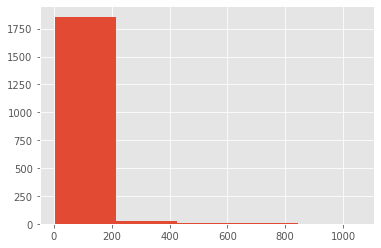

In [23]:
plt.hist([len(s) for s in sentences], bins=5)
plt.show()

In [24]:
max([len(s) for s in sentences])

1056

In [25]:
max_len = 93 #selected value outisde the histogram

### Utils

In [26]:
word2idx = {w: i + 1 for i, w in enumerate(VOCAB)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [27]:
word2idx["ENDPAD"]

7520

In [28]:
tag2idx["B-Material"]

2

In [29]:
idx2tag = {i: w for w, i in tag2idx.items()}
index2word = {i: w for w, i in word2idx.items()}

### X & Y Prep

In [30]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def getXYFromSentences(sentences):
  
  X = [[word2idx[w[0]] for w in s] for s in sentences]
  X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx["ENDPAD"])
   
  y = [[tag2idx[w[1]] for w in s] for s in sentences]
  y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
  y = np.array([to_categorical(i, num_classes=n_tags) for i in y])
  return X, y

Using TensorFlow backend.


In [31]:
X_train, y_train = getXYFromSentences(sentences)

In [32]:
X_test, y_test = getXYFromSentences(sentences_test)

#### Exploration

In [33]:
target = X_test[1]

In [34]:
target

array([ 968, 3890,  622, 5156, 5697, 5028, 6650, 6842, 4382, 1840, 6573,
        650, 1125, 1927, 2737, 5473, 5449, 6007, 4553, 4254,  477, 2781,
       5091, 6640, 6038, 1927, 1593, 1154, 4288,  716, 1154, 4666, 7046,
       1238, 1154, 4288, 6513, 1154,  838, 7046, 2331, 2062, 7520, 7520,
       7520, 7520, 7520, 7520, 7520, 7520, 7520, 7520, 7520, 7520, 7520,
       7520, 7520, 7520, 7520, 7520, 7520, 7520, 7520, 7520, 7520, 7520,
       7520, 7520, 7520, 7520, 7520, 7520, 7520, 7520, 7520, 7520, 7520,
       7520, 7520, 7520, 7520, 7520, 7520, 7520, 7520, 7520, 7520, 7520,
       7520, 7520, 7520, 7520, 7520], dtype=int32)

In [35]:
np.asarray([index2word[i] for i in  target])

array(['Lab', 'analyses', 'were', 'carried', 'from', '2009', 'to', '2011',
       'The', 'Gutianshan', 'National', 'Nature', 'Reserve', '(', 'NNR',
       ')', 'is', 'located', 'in', 'the', 'western', 'part', 'of',
       'Zhejiang', 'Province', '(', "29o8'18", "''", 'â\x80\x93',
       "29o17'29", "''", 'N', ',', "118o2'14", "''", 'â\x80\x93',
       "118o11'12", "''", 'E', ',', 'Fig', '.', 'ENDPAD', 'ENDPAD',
       'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD',
       'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD',
       'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD',
       'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD',
       'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD',
       'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD',
       'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD',
       'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD',
       'ENDPAD'], dtype='<U10')

In [36]:
target = y_train[1]

In [37]:
target.shape


(93, 9)

In [38]:
np.asarray([idx2tag[np.argmax(i)] for i in  target])

array(['O', 'O', 'O', 'O', 'O', 'B-Material', 'B-Quality', 'O', 'O', 'O',
       'B-Material', 'B-Material', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Material', 'O',
       'B-Quality', 'I-Quality', 'O', 'B-Quality', 'I-Quality', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Material', 'B-Material',
       'B-Quality', 'O', 'O', 'O', 'O', 'B-Quality', 'O', 'B-Material',
       'B-Material', 'B-Quality', 'O', 'O', 'O', 'B-Quality', 'O', 'O',
       'B-Material', 'O', 'O', 'O', 'B-Material', 'B-Material',
       'B-Quality', 'B-Material', 'B-Material', 'B-Quality', 'B-Quality',
       'O', 'O', 'B-Material', 'O', 'O'], dtype='<U10')

## BiLSTM Model

In [39]:
from keras import callbacks
from keras.models import Model, Input, model_from_json
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.optimizers import RMSprop

In [40]:
def create_model():
  input = Input(shape=(max_len,))
  #in the line below --> laurance set the input_length = max_len-1 (NLP in TF Week4)
  model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
  model = Dropout(rate=0.1)(model)
  model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
  out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer
  
  return Model(input, out)

In [41]:
model = create_model()
#model = load_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [42]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 93)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 93, 50)            376000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 93, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 93, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 93, 9)             1809      
Total params: 498,609
Trainable params: 498,609
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(optimizer=RMSprop(), loss="categorical_crossentropy", metrics=["accuracy"])

In [44]:
class myCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=0.989):
      print("\nReached 98.9% accuracy so cancelling training!")
      self.model.stop_training = True
 

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20)

In [47]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1521, 93)
(381, 93)
(324, 93)
(1521, 93, 9)
(381, 93, 9)
(324, 93, 9)


In [48]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), shuffle=True, batch_size=32, epochs=10, verbose=1, callbacks=[myCallback()])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1521 samples, validate on 381 samples
Epoch 1/10
1521/1521 [==============================] - 10s 7ms/step - loss: 0.2945 - accuracy: 0.9621 - val_loss: 0.1047 - val_accuracy: 0.9824
Epoch 2/10
1521/1521 [==============================] - 8s 5ms/step - loss: 0.1151 - accuracy: 0.9809 - val_loss: 0.0959 - val_accuracy: 0.9824
Epoch 3/10
1521/1521 [==============================] - 8s 5ms/step - loss: 0.0996 - accuracy: 0.9808 - val_loss: 0.0866 - val_accuracy: 0.9823
Epoch 4/10
1521/1521 [==============================] - 8s 5ms/step - loss: 0.0829 - accuracy: 0.9809 - val_loss: 0.0724 - val_accuracy: 0.9825
Epoch 5/10
1521/1521 [==============================] - 8s 5ms/step - loss: 0.0676 - accuracy: 0.9822 - val_loss: 0.0581 - val_accuracy: 0.9853
Epoch 6/10
1521/1521 [==============================] - 8s 5ms/step - loss: 0.0568 - accuracy: 0.9844 - val_loss: 0.0528 - val_accuracy: 

In [49]:
# save_model(model)

In [50]:
hist = pd.DataFrame(history.history)

In [51]:
saveDataFrameToCSV(hist, training_history_csv, append=True)
 

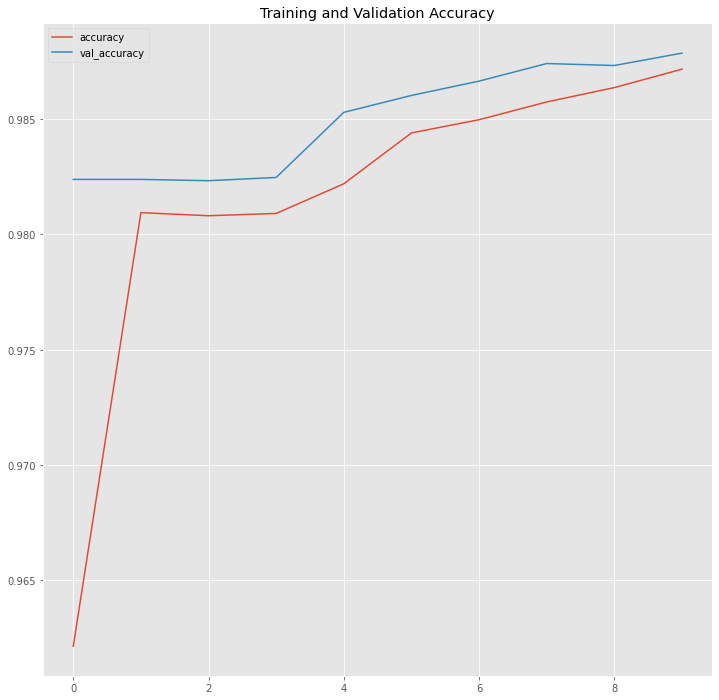

In [52]:
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["val_accuracy"], label="val_accuracy")
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [66]:
i = 5

p = model.predict(np.array([X_train[i]]))
p = np.argmax(p, axis=-1)

true_lbl = y_train[i]
true_lbl = np.argmax(true_lbl, axis=-1)

print("{:15} {:20}: {}".format("Word", "True", "Pred"))

for w, t, pred in zip(X_train[i], true_lbl, p[0]):    
    print("{:15}: {:20}: {}" .format(index2word[w], tags[t], tags[pred]))

Word            True                : Pred
(              : O                   : O
2001           : O                   : O
)              : O                   : O
using          : O                   : O
fluorescent    : B-Quality           : O
4-methylumbelliferone: B-Material          : O
substrates     : O                   : O
(              : O                   : O
4-MUF          : O                   : O
;              : O                   : O
Sigma-Aldrich  : O                   : O
,              : O                   : O
St.            : O                   : O
Louis          : O                   : O
,              : O                   : O
USA            : O                   : O
)              : O                   : O
and            : O                   : O
a              : O                   : O
buffered       : O                   : O
solution       : O                   : O
(              : O                   : O
pH             : B-Quality           : B-Quality


## Evaluation

In [54]:
model.evaluate(x=X_test, y=y_test, batch_size=32, verbose=1)

324/324 [==============================] - 1s 2ms/step


[0.06014179916661463, 0.986758291721344]

In [55]:
test_pred = model.predict(X_test, verbose=1)

324/324 [==============================] - 1s 2ms/step


In [56]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("ENDPAD", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("ENDPAD", "O"))
        out.append(out_i)
    return out

In [57]:
def toLabel(pred):
    out = []
    for pred_i in pred:        
        out.append(np.asarray([idx2tag[np.argmax(i)] for i in  pred_i]))
    return np.asarray(out)


In [69]:
pred_labels = pred2label(test_pred)
test_labels = test2label(np.argmax(y_test, -1))

In [70]:
print(pred_labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [71]:
print(test_labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


### Evaluation


In [61]:
from classification_metrics import classification_report, replaceMultiple

In [74]:
test_labels = [val for sublist in test_labels for val in sublist]
pred_labels = [val for sublist in pred_labels for val in sublist]

In [75]:
print(classification_report(test_labels, pred_labels))

                        precision 	 recall 	 f1-score 	 support

I-Environment       	 0.00		 0.00		 0.00		 36	
B-Material          	 0.76		 0.23		 0.35		 226	
B-Quality           	 0.93		 0.73		 0.82		 297	
B-Process           	 0.00		 0.00		 0.00		 3	
B-Environment       	 0.74		 0.70		 0.72		 215	
I-Quality           	 0.00		 0.00		 0.00		 20	


macro avg           	 0.41		 0.28		 0.33		 797	
micro avg           	 0.83		 0.53		 0.65		 797	



Here, we try to normalize the class, no disincition between the **B**egining or **I**ntermediate of the class (`B-Material` = `I-Material` = `Material`)

In [76]:
test_labels = [replaceMultiple(val, ["B-","I-"], "") for val in test_labels ]
pred_labels = [replaceMultiple(val, ["B-","I-"], "") for val in pred_labels ]

In [77]:
print(classification_report(test_labels, pred_labels))

                        precision 	 recall 	 f1-score 	 support

Quality             	 0.93		 0.69		 0.79		 317	
Material            	 0.76		 0.23		 0.35		 226	
Process             	 0.00		 0.00		 0.00		 3	
Environment         	 0.76		 0.62		 0.68		 251	


macro avg           	 0.61		 0.38		 0.47		 797	
micro avg           	 0.84		 0.53		 0.65		 797	

